<h1> Data Science/Machine Learning Code Walkthrough</h1>
<h3>Fall 2020, OIDD 899 </h3>

Kartik Hosanagar, Daehwan Ahn, Alex Miller

{kartikh, ahndh, alexmill} @ wharton.upenn.edu

---

Main goals:
- Understand basics of working with raw data in ML
- Understand what "machine learning" looks like in practice
- Get a sense of where fancy methods help and where they don't
- Give you a jumping off point if you want to learn more

(I will be walking through the code for illustrative purposes, but I can't teach you how to program in 20 minutes!)

# Code setup

In [ ]:
# Import Packages
%matplotlib inline

# Data Handling
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100 #handy for showing truncated results

# Visualization
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# Stats and Machine Learning Toolds
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# System
import tqdm
from tqdm import tqdm
import sys
import warnings
from copy import copy
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Dataset: Online Dating Profiles

This is a useful, publicly available dataset for demonstrating some common data science techniques ([data source](https://www.kaggle.com/annavictoria/speed-dating-experiment)). We'll build some toy examples here, but the methods/principles are easily generalizable to other datasets.

# Part 1: Basic Data Processing and Prediction

In [ ]:
# Upload data file ("OIDD 899 - Speed Dating.csv")
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

### Question: Based on given information such as demographics of the couple and their ratings of each other, can we predict whether or not couples that had met through speed dating will want another date?

In business contexts: similar methods can be used to use somebody's profile on your website to predict whether they would be interested in your product.

In [ ]:
# Let's use just these features to try to predict a couple's matching
df = pd.read_csv('OIDD 899 - Speed Dating.csv')
data = copy(df)
print("Data Shape:", data.shape)
data.head()

Data Shape: (2080, 19)


,Woman's Age,Man's Age,Woman's Race,Man's Race,Same Race,Woman's Attractive,Woman's Sincere,Woman's Intelligent,Woman's Fun,Woman's Ambitious,Woman's SharedInterests,Man's Attractive,Man's Sincere,Man's Intelligent,Man's Fun,Man's Ambitious,Man's SharedInterests,Interests Correlation,True_Match
0,26,26,European/Caucasian-American,European/Caucasian-American,1,5.0,6,7.0,6,6,6,8.0,9.0,6.0,8.0,5.0,7.0,0.57,0
1,29,27,European/Caucasian-American,Other,0,3.0,7,8.0,6,8,2,6.0,8.0,7.0,6.0,7.0,6.0,0.72,0
2,28,26,European/Caucasian-American,Asian/Pacific-Islander/Asian-American,0,7.0,9,10.0,10,10,8,6.0,5.0,7.0,6.0,5.0,5.0,0.08,0
3,25,27,Asian/Pacific-Islander/Asian-American,European/Caucasian-American,0,7.0,7,7.0,7,7,7,4.0,9.0,9.0,2.0,9.0,2.0,-0.32,0
4,27,28,Asian/Pacific-Islander/Asian-American,European/Caucasian-American,0,7.0,7,8.0,6,4,4,4.0,6.0,8.0,4.0,9.0,1.0,-0.18,0


### But wait...
**Question:** How do we get a computer to "understand" a person's dating profile?

**Answer:** Math! (matrices, linear algebra).

In [ ]:
# Some columns are "categorical"
# e.g., Woman's Race, Man's Race
data["Woman's Race"].head(n=10)

0              European/Caucasian-American
1              European/Caucasian-American
2              European/Caucasian-American
3    Asian/Pacific-Islander/Asian-American
4    Asian/Pacific-Islander/Asian-American
5    Asian/Pacific-Islander/Asian-American
6              European/Caucasian-American
7              European/Caucasian-American
8              European/Caucasian-American
9              European/Caucasian-American
Name: Woman's Race, dtype: object

In [ ]:
pd.get_dummies(data["Woman's Race"]).head(n=10)

,Asian/Pacific-Islander/Asian-American,Black/African-American,European/Caucasian-American,Latino/Hispanic-American,Other
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
6,0,0,1,0,0
7,0,0,1,0,0
8,0,0,1,0,0
9,0,0,1,0,0


In [ ]:
categorical_columns = ["Woman's Race", "Man's Race"]
numeric_columns = [col for col in data.columns if col not in categorical_columns]

for col in categorical_columns:
    dummy_cols = pd.get_dummies(data[col])
    dummy_cols.columns = [f'{col}: {value}' for value in dummy_cols.columns]
    data = data.join(dummy_cols)
    data = data.drop(columns=[col])

data.head(n=10)

,Woman's Age,Man's Age,Same Race,Woman's Attractive,Woman's Sincere,Woman's Intelligent,Woman's Fun,Woman's Ambitious,Woman's SharedInterests,Man's Attractive,Man's Sincere,Man's Intelligent,Man's Fun,Man's Ambitious,Man's SharedInterests,Interests Correlation,True_Match,Woman's Race: Asian/Pacific-Islander/Asian-American,Woman's Race: Black/African-American,Woman's Race: European/Caucasian-American,Woman's Race: Latino/Hispanic-American,Woman's Race: Other,Man's Race: Asian/Pacific-Islander/Asian-American,Man's Race: Black/African-American,Man's Race: European/Caucasian-American,Man's Race: Latino/Hispanic-American,Man's Race: Other
0,26,26,1,5.0,6,7.0,6,6,6,8.0,9.0,6.0,8.0,5.0,7.0,0.57,0,0,0,1,0,0,0,0,1,0,0
1,29,27,0,3.0,7,8.0,6,8,2,6.0,8.0,7.0,6.0,7.0,6.0,0.72,0,0,0,1,0,0,0,0,0,0,1
2,28,26,0,7.0,9,10.0,10,10,8,6.0,5.0,7.0,6.0,5.0,5.0,0.08,0,0,0,1,0,0,1,0,0,0,0
3,25,27,0,7.0,7,7.0,7,7,7,4.0,9.0,9.0,2.0,9.0,2.0,-0.32,0,1,0,0,0,0,0,0,1,0,0
4,27,28,0,7.0,7,8.0,6,4,4,4.0,6.0,8.0,4.0,9.0,1.0,-0.18,0,1,0,0,0,0,0,0,1,0,0
5,21,29,0,8.0,9,9.0,8,8,7,4.0,8.0,8.0,8.0,7.0,4.0,-0.04,0,1,0,0,0,0,0,0,1,0,0
6,22,27,1,6.0,3,4.0,2,4,2,6.0,5.0,7.0,6.0,5.0,5.0,0.52,0,0,0,1,0,0,0,0,1,0,0
7,35,29,1,9.0,8,10.0,9,8,9,4.0,7.0,7.0,5.0,5.0,5.0,0.66,0,0,0,1,0,0,0,0,1,0,0
8,29,27,1,9.0,8,7.0,8,6,6,4.0,7.0,7.0,6.0,5.0,5.0,0.60,0,0,0,1,0,0,0,0,1,0,0
9,24,24,1,4.0,8,8.0,6,8,6,9.0,9.0,9.0,8.0,9.0,7.0,0.35,0,0,0,1,0,0,0,0,1,0,0


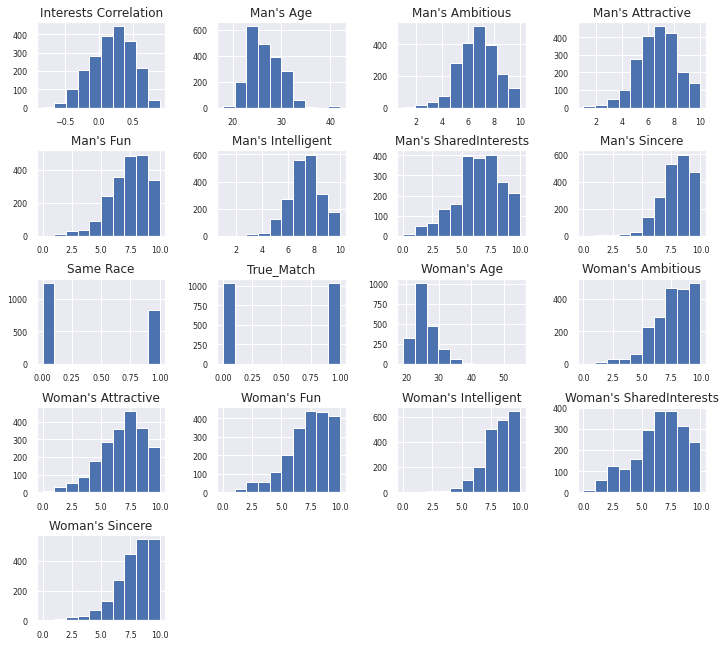

In [ ]:
# Let's check the distribution of variables
params = {'axes.titlesize':'12',
          'xtick.labelsize':'8',
          'ytick.labelsize':'8'}
plt.rcParams.update(params)
data[numeric_columns].hist(bins=10, figsize=(12,11))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.5)
plt.show()

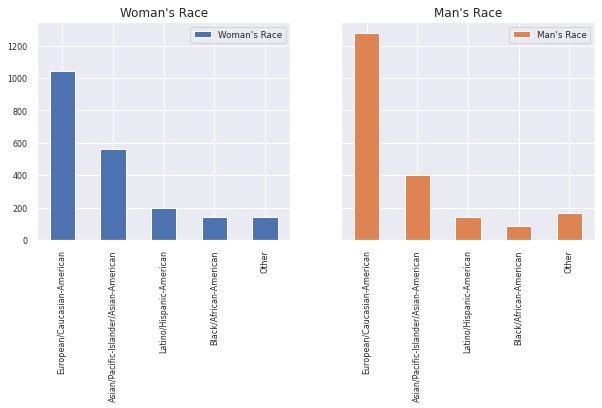

In [ ]:
categorical_counts = pd.DataFrame(df["Woman's Race"].value_counts())
categorical_counts = categorical_counts.join(df["Man's Race"].value_counts())
_ = categorical_counts.plot(kind='bar', subplots=True, sharey=True, layout=(1,2), figsize=(10,4))

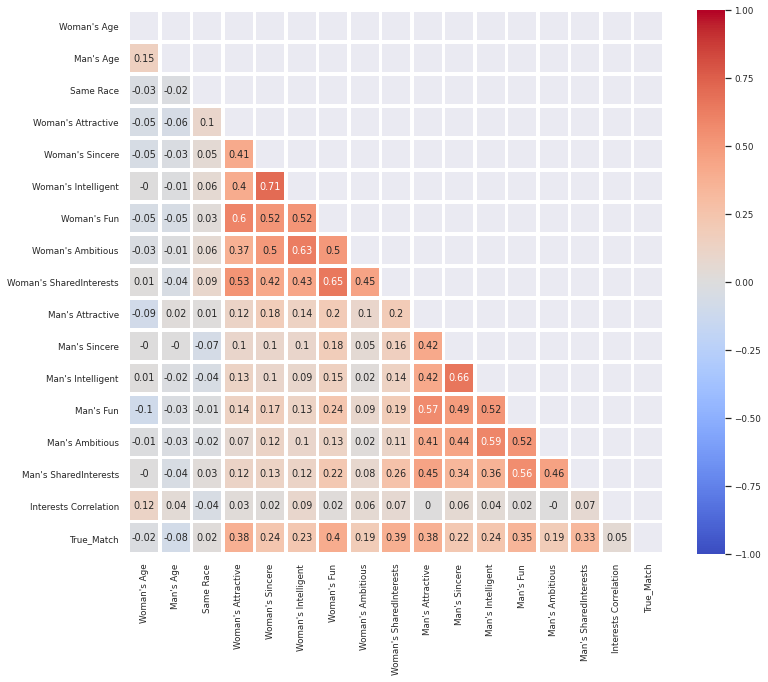

In [ ]:
# Let's check the correlation among variables

XY = data[numeric_columns].copy()
header_name = list(XY)
sns.set(font_scale=0.8)
X_float = pd.DataFrame(XY.astype(float))
corr_df = X_float.corr(method='pearson')

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

rcParams['figure.figsize'] = 12, 10
sns.heatmap(corr_df.round(2), cmap='coolwarm', vmax=1.0, vmin=-1.0 , mask=mask, linewidths=2.5, xticklabels=header_name, yticklabels=header_name, annot=True)
plt.yticks(rotation=0) 
plt.xticks(rotation=90)
plt.show()

### Outcome variable: Match(1) or Not Match(0)

In [ ]:
data.True_Match.value_counts()

1    1040
0    1040
Name: True_Match, dtype: int64

## The magic: "machine learning"!

In [ ]:
# Building a basic logistic regression classifier
# using features to predict Match or Not
X = data.drop(['True_Match'], axis=1)
Y = data.True_Match

from sklearn.linear_model import LogisticRegression

match_logit = LogisticRegression(max_iter=500)
match_logit.fit(X,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
logit_predictions = pd.DataFrame({
    "prediction": match_logit.predict(X),
    "ground_truth": Y
})

logit_predictions['correct'] = (logit_predictions.prediction == logit_predictions.ground_truth)
logit_predictions.head(n=10)

,prediction,ground_truth,correct
0,1,0,False
1,0,0,True
2,1,0,False
3,0,0,True
4,0,0,True
5,0,0,True
6,0,0,True
7,1,0,False
8,0,0,True
9,0,0,True


In [ ]:
# We usually think of "True" as 1 and "False" as 0
logit_predictions.astype(int).head()

,prediction,ground_truth,correct
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1


In [ ]:
# Evaluate overall accuracy:
logit_accuracy = logit_predictions.correct.mean()
print(f"Logistic regression accuracy: {logit_accuracy*100:.2f}%")

Logistic regression accuracy: 75.58%


Note there are other ways of thinking about "accuracy":
- Precision: Among all observations which are predicted to be matches, how many actually are?
- Recall: Among all observations that are actual matches, how many did the algorithm correctly predict?


In [ ]:
f"Precision: {logit_predictions.loc[logit_predictions.prediction==1,'correct'].mean()*100:.2f}"

'Precision: 75.19'

In [ ]:
f"Recall: {logit_predictions.loc[logit_predictions.ground_truth==1,'correct'].mean()*100:.2f}"

'Recall: 76.35'

In balanced data sets (i.e., when the number ground truth labels appear in equal proportion), most versions of "accuracy" are similar. However, in unbalanced data sets (e.g., when you have many examples of one outcome and few examples of the alternative), choosing your accuracy measure appropriately becomes very important.

## Model comparison

We'll try making the same prediction, using different machine learning models:

- Logistic regression
- Decision tree
- Random forest

In [ ]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

match_logit = LogisticRegression(max_iter=500)
match_logit.fit(X, Y)
round((match_logit.predict(X)==Y).mean()*100, 2)

75.58

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

match_dt = DecisionTreeClassifier(max_depth=15)
match_dt.fit(X, Y)
round((match_dt.predict(X)==Y).mean()*100, 2)

98.8

In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

match_rf = RandomForestClassifier(n_estimators=100, max_depth=15)
match_rf.fit(X,Y)
round((match_rf.predict(X)==Y).mean()*100, 2)

99.9

### Cross-validated Accuracy and Model Comparison

Bear in mind that "in-sample" performance does not equal what most people care about then we discuss model performance or accuracy generally. What we really want to know is if our model can make correct predictions on data it has never seen before. Cross validation is a simple method for simulating the performance of a prediction algorithm on out-of-sample data (i.e., data it was not trained on).

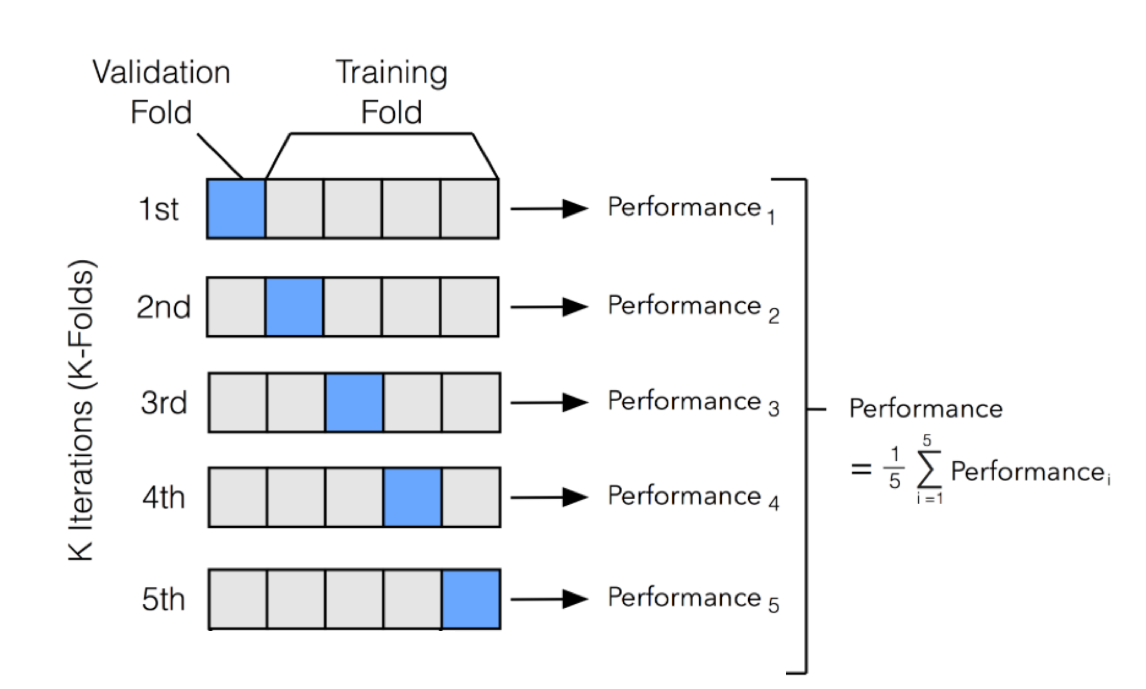

[Image source](http://ethen8181.github.io/machine-learning/model_selection/model_selection.html). Contains a nice walkthrough of model training/tuning at one level higher than this notebook.

 Logistic Regression: 0.75 (0.017)
       Decision Tree: 0.84 (0.018)
       Random Forest: 0.89 (0.015)


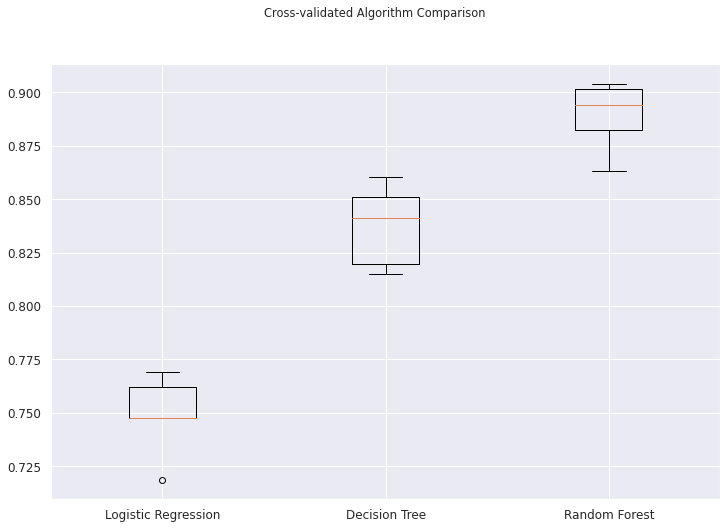

In [ ]:
# This code compares the cross-validated performance of various ML models
X = data.drop(['True_Match'], axis=1)
y = data.True_Match

# Test options and evaluation metric
num_folds = 5
scoring = 'accuracy'

# Spot-Check Algorithms
models = []
models.append(('Logistic Regression', LogisticRegression(max_iter=1000)))
#models.append(('K Nearest Neighbor', KNeighborsClassifier()))
#models.append(('Naive Bayesian', GaussianNB()))
#models.append(('SVM', SVC()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100)))

results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=False, shuffle=True)
  cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = f"{name: >20}: {cv_results.mean():.02f} ({cv_results.std():.03f})"
  print(msg)

# Compare Algorithms
params = {
    'figure.figsize': (12,8),
    'axes.titlesize':'16',
    'xtick.labelsize':'12',
    'ytick.labelsize':'12'
}
plt.rcParams.update(params)

fig = pyplot.figure()
fig.suptitle('Cross-validated Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## A few takeaways:

- Accuracy is better with a fancy method like Random Forests, but not perfect; this algorithm will still make many mistaken predictions (~90% accuracy).
    - Truly high-stakes decisions should always be made with care and mistakes must be factored in
- Modern ML methods often only shine with truly *big data* (10k, 100k, 1m+ observations)
    - Model accuracies of 98%+ are often achieved with more data, rather than better algorithms
    - Huge data of this sort is not common in most organizations (outside Google, FB, Amazon, Twitter, etc.)
    - Lots of news is biased toward breakthroughs at these big comapnies... rarely relevant for business practitioners
- The code to run different algorithms is remarkably similar
    - With tools like Python/SciKit-Learn, ML coding is a commodity!
    - Much more value is added in data collecting / processing / labeling than in mathematical modeling.
